Leader Statements: [1, 3, 4, 12]

Basic Blocks:
B1: ['sum=0', 'i=0']
B2: ['if i>n goto 12']
B3: ['t1=addr(a)', 't2=i*4', 't3=t1[t2]', 't4=sum+t3', 'sum=t1', 't5=i+1', 'i=t5', 'goto 3']
B4: ['return sum']

Program Flow Graph:
B1 -> ['B2']
B2 -> ['B3', 'B4']
B3 -> ['B2']
B4 -> []

Dominators:
B2: {'B2', 'B1'}
B4: {'B2', 'B4', 'B1'}
B3: {'B2', 'B3', 'B1'}
B1: {'B1'}

Natural Loops: [('B3', 'B2')]
GEN = {'B1': {1, 2}, 'B2': set(), 'B3': {4, 5, 6, 7, 8, 9, 10}, 'B4': set()}
KILL = {'B1': {8, 10}, 'B2': set(), 'B3': {1, 2}, 'B4': set()}
Predecessors: {'B1': set(), 'B2': {'B3', 'B1'}, 'B3': {'B2'}, 'B4': {'B2'}}


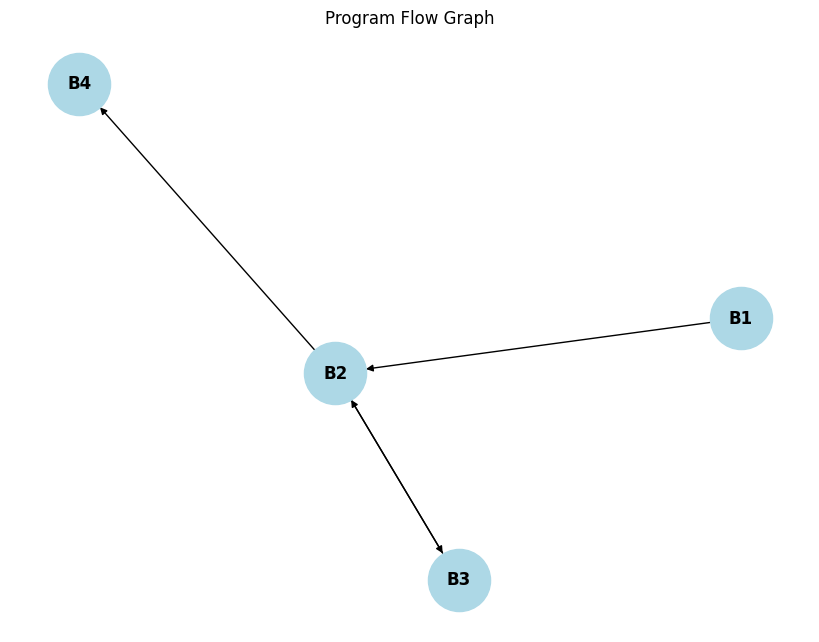

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# ----------------------------
# Leader Detection
# ----------------------------
def find_leaders(statements):
    leaders = {1}
    for i, stmt in enumerate(statements, start=1):
        if "goto" in stmt:
            target = int(stmt.split("goto")[1].strip())
            leaders.add(target)
            if "if" in stmt.lower() and i + 1 <= len(statements):
                leaders.add(i + 1)
    return sorted(leaders)


# ----------------------------
# Basic Blocks Formation
# ----------------------------
def form_basic_blocks(statements, leaders):
    basic_blocks = []
    block = []
    for i, stmt in enumerate(statements, start=1):
        if i in leaders and block:
            basic_blocks.append(block)
            block = []
        block.append((i, stmt))
    if block:
        basic_blocks.append(block)

    stmt_to_block = map_statements_to_blocks(basic_blocks)
    return basic_blocks, stmt_to_block


def map_statements_to_blocks(basic_blocks):
    stmt_to_block = {}
    for block_idx, block in enumerate(basic_blocks):
        for stmt in block:
            stmt_to_block[stmt[0]] = f"B{block_idx + 1}"
    return stmt_to_block


# ----------------------------
# Flow Graph Construction
# ----------------------------
def construct_flow_graph(basic_blocks, stmt_to_block):
    flow_graph = {f"B{i + 1}": set() for i in range(len(basic_blocks))}
    for i, block in enumerate(basic_blocks):
        last_stmt_num, last_stmt = block[-1]
        block_name = f"B{i + 1}"

        if "if" in last_stmt and "goto" in last_stmt:
            handle_conditional_goto(flow_graph, stmt_to_block, block_name, last_stmt, i, basic_blocks)
        elif "goto" in last_stmt:
            handle_unconditional_goto(flow_graph, stmt_to_block, block_name, last_stmt)
        elif i + 1 < len(basic_blocks):
            flow_graph[block_name].add(f"B{i + 2}")

    return {k: sorted(list(v)) for k, v in flow_graph.items()}


def handle_unconditional_goto(flow_graph, stmt_to_block, block_name, stmt):
    target_stmt = int(stmt.split("goto")[1].strip())
    if target_stmt in stmt_to_block:
        flow_graph[block_name].add(stmt_to_block[target_stmt])


def handle_conditional_goto(flow_graph, stmt_to_block, block_name, stmt, index, basic_blocks):
    target_stmt = int(stmt.split("goto")[1].strip())
    if target_stmt in stmt_to_block:
        flow_graph[block_name].add(stmt_to_block[target_stmt])
    if index + 1 < len(basic_blocks):
        flow_graph[block_name].add(f"B{index + 2}")


# ----------------------------
# Dominators & Loop Detection
# ----------------------------
def find_dominators(basic_blocks, flow_graph):
    nodes = {f"B{i + 1}" for i in range(len(basic_blocks))}
    dominators = {n: set(nodes) for n in nodes}
    dominators["B1"] = {"B1"}

    changed = True
    while changed:
        changed = False
        for node in nodes - {"B1"}:
            preds = get_predecessors(flow_graph, node)
            new_doms = set(nodes)
            for pred in preds:
                new_doms.intersection_update(dominators[pred])
            new_doms.add(node)
            if dominators[node] != new_doms:
                dominators[node] = new_doms
                changed = True
    return dominators


def get_predecessors(flow_graph, target_node):
    return [node for node, succs in flow_graph.items() if target_node in succs]


def detect_loops(flow_graph, dominators):
    return [(node, succ) for node, successors in flow_graph.items() for succ in successors if succ in dominators[node]]


# ----------------------------
# GEN & KILL Set Computation
# ----------------------------
def compute_gen_kill(basic_blocks):
    gen, kill, defined_vars = {}, {}, {}

    for block_idx, block in enumerate(basic_blocks):
        block_name = f"B{block_idx + 1}"
        gen[block_name] = set()

        for stmt_num, stmt in block:
            if "=" in stmt and "goto" not in stmt:
                var_name = stmt.split("=")[0].strip()
                gen[block_name].add(stmt_num)
                defined_vars.setdefault(var_name, []).append((block_name, stmt_num))

    for block_name in gen:
        kill[block_name] = compute_kill_set(gen, block_name, defined_vars)

    return gen, kill


def compute_kill_set(gen, block_name, defined_vars):
    kill_set = set()
    for var, defs in defined_vars.items():
        defs_in_other_blocks = [stmt_num for b, stmt_num in defs if b != block_name]
        if any(stmt_num in gen[block_name] for _, stmt_num in defs):
            kill_set.update(defs_in_other_blocks)
    return kill_set


# ----------------------------
# Predecessor Calculation
# ----------------------------
def compute_predecessors(flow_graph):
    predecessors = {node: set() for node in flow_graph}
    for node, successors in flow_graph.items():
        for succ in successors:
            predecessors[succ].add(node)
    return predecessors


# ----------------------------
# Visualization
# ----------------------------
def visualize_flow_graph(flow_graph):
    G = nx.DiGraph()
    for node, successors in flow_graph.items():
        for succ in successors:
            G.add_edge(node, succ)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="black", node_size=2000,
            font_size=12, font_weight="bold")
    plt.title("Program Flow Graph")
    plt.show()


# ----------------------------
# Driver Code
# ----------------------------
statements = [
    "sum=0",        # L1
    "i=0",
    "if i>n goto 12",  # L2
    "t1=addr(a)",   # L3
    "t2=i*4",
    "t3=t1[t2]",
    "t4=sum+t3",
    "sum=t1",
    "t5=i+1",
    "i=t5",
    "goto 3",
    "return sum"    # L4
]

leaders = find_leaders(statements)
basic_blocks, stmt_to_block = form_basic_blocks(statements, leaders)
flow_graph = construct_flow_graph(basic_blocks, stmt_to_block)
dominators = find_dominators(basic_blocks, flow_graph)
loops = detect_loops(flow_graph, dominators)
gen, kill = compute_gen_kill(basic_blocks)
predecessors = compute_predecessors(flow_graph)

# Output
print("Leader Statements:", leaders)
print("\nBasic Blocks:")
for i, block in enumerate(basic_blocks, start=1):
    print(f"B{i}: {[stmt[1] for stmt in block]}")
print("\nProgram Flow Graph:")
for k, v in flow_graph.items():
    print(f"{k} -> {v}")
print("\nDominators:")
for k, v in dominators.items():
    print(f"{k}: {v}")
print("\nNatural Loops:", loops)
print("GEN =", gen)
print("KILL =", kill)
print("Predecessors:", predecessors)

visualize_flow_graph(flow_graph)

In [ ]:
IN = {block: set() for block in gen}
OUT = {block: gen[block].copy() for block in gen}

def print_sets(iteration):
    print(f"\nIteration {iteration}")
    for block in sorted(gen.keys()):
        print(f"Block {block}:")
        print(f"  IN[{block}]  = {sorted(list(IN[block]))}")
        print(f"  OUT[{block}] = {sorted(list(OUT[block]))}")

print_sets("Initial")

iteration = 0
change = True

while change:
    iteration += 1
    change = False

    IN_prev = IN.copy()
    OUT_prev = OUT.copy()

    for block in sorted(gen.keys()):
        if predecessors[block]:
            IN[block] = set().union(*(OUT_prev[p] for p in predecessors[block]))
        else:
            IN[block] = set()

        OUT[block] = gen[block].union(IN[block] - kill[block])

    print_sets(iteration)

    if IN != IN_prev or OUT != OUT_prev:
        change = True
    else:
        print("Reached a stable state. Stopping iteration.")
        break



Iteration Initial
Block B1:
  IN[B1]  = []
  OUT[B1] = [1, 2]
Block B2:
  IN[B2]  = []
  OUT[B2] = []
Block B3:
  IN[B3]  = []
  OUT[B3] = [4, 5, 6, 7, 8, 9, 10]
Block B4:
  IN[B4]  = []
  OUT[B4] = []

Iteration 1
Block B1:
  IN[B1]  = []
  OUT[B1] = [1, 2]
Block B2:
  IN[B2]  = [1, 2, 4, 5, 6, 7, 8, 9, 10]
  OUT[B2] = [1, 2, 4, 5, 6, 7, 8, 9, 10]
Block B3:
  IN[B3]  = []
  OUT[B3] = [4, 5, 6, 7, 8, 9, 10]
Block B4:
  IN[B4]  = []
  OUT[B4] = []

Iteration 2
Block B1:
  IN[B1]  = []
  OUT[B1] = [1, 2]
Block B2:
  IN[B2]  = [1, 2, 4, 5, 6, 7, 8, 9, 10]
  OUT[B2] = [1, 2, 4, 5, 6, 7, 8, 9, 10]
Block B3:
  IN[B3]  = [1, 2, 4, 5, 6, 7, 8, 9, 10]
  OUT[B3] = [4, 5, 6, 7, 8, 9, 10]
Block B4:
  IN[B4]  = [1, 2, 4, 5, 6, 7, 8, 9, 10]
  OUT[B4] = [1, 2, 4, 5, 6, 7, 8, 9, 10]

Iteration 3
Block B1:
  IN[B1]  = []
  OUT[B1] = [1, 2]
Block B2:
  IN[B2]  = [1, 2, 4, 5, 6, 7, 8, 9, 10]
  OUT[B2] = [1, 2, 4, 5, 6, 7, 8, 9, 10]
Block B3:
  IN[B3]  = [1, 2, 4, 5, 6, 7, 8, 9, 10]
  OUT[B3] = [4, 5, 6,

In [ ]:
def calculate_ud_chains(statements, IN):
    ud_chains = {}

    for stmt_num, statement in statements.items():
        parts = statement.split("=")

        if len(parts) > 1:
            defined_var = parts[0].strip()
            used_vars = [var for var in parts[1].strip().split()
                         if var.isalpha() and var not in ("addr", "[", "]")]

            ud_chains.setdefault(defined_var, []).append(stmt_num)

            for var in used_vars:
                ud_chains.setdefault(var, [])
                if var not in ud_chains:
                  ud_chains[var].extend([def_num for def_num in IN[block_name] if statements[def_num].startswith(var + "=")])
                else: # Case 2
                  ud_chains[var].append(stmt_num)

        else:
            pass

    return ud_chains

def generate_mappings(statements, basic_blocks):
    stmt_map = {i + 1: stmt for i, stmt in enumerate(statements)}

    stmt_to_block = {}
    for block_idx, block in enumerate(basic_blocks, start=1):
        block_name = f"B{block_idx}"
        for stmt_num, _ in block:
            stmt_to_block[stmt_num] = block_name

    return stmt_map, stmt_to_block

stmt_map, stmt_to_block = generate_mappings(statements, basic_blocks)

ud_chains = calculate_ud_chains(stmt_map, IN)

for var, chain in ud_chains.items():
    print(f"UD-Chain for {var}: {chain}")

def get_loop_statements(loops, stmt_to_block):
    loop_statements = set()
    for loop in loops:
        header, back_edge = loop
        for stmt, block in stmt_to_block.items():
            if block == back_edge or block == header:
                loop_statements.add(stmt)
    return loop_statements

def identify_loop_invariants(ud_chains, loop_statements):
    invariants = []
    for var, chain in ud_chains.items():
        if all(stmt not in loop_statements for stmt in chain):
            invariants.append(var)
    return invariants
loop_statements = get_loop_statements(loops, stmt_to_block)
invariants = identify_loop_invariants(ud_chains, loop_statements)
print("\nLoop Statements:", loop_statements)
print("\nLoop Invariants:", invariants)

UD-Chain for sum: [1, 8]
UD-Chain for i: [2, 10]
UD-Chain for t1: [4]
UD-Chain for t2: [5]
UD-Chain for t3: [6]
UD-Chain for t4: [7]
UD-Chain for t5: [9]

Loop Statements: {3, 4, 5, 6, 7, 8, 9, 10, 11}

Loop Invariants: []
